In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, NuSVC



In [2]:
df = pd.read_csv("data.csv", encoding='latin-1')
# drop salary missing rows
df=df.dropna(subset='salary')
df = df.reset_index(drop=True)
year_count = 0
month_count = 0
week_count = 0
day_count = 0
hour_count = 0
unit_count = 0

from_count = 0
upto_count = 0 
dash_count = 0
interval_year_idx = []
# year_dash = []
other = []

for idx, salary in enumerate(df['salary'], 0):
    hour = re.search(r'hour', salary)
    day = re.search(r'day', salary)
    week = re.search(r'week', salary)
    month = re.search(r'month', salary)
    year = re.search(r'year', salary)
    from_ = re.search(r'From', salary)
    upto = re.search(r'Up', salary)
    dash = re.search(r'-', salary)
    if hour:
        hour_count += 1
    elif day:
        day_count += 1
    elif week:
        week_count += 1
    elif month:
        month_count += 1
    elif year:
        year_count += 1
        if dash:
            interval_year_idx.append(idx)
            # year_dash.append(salary)
    else:
        unit_count += 1
        
    if from_:
        from_count += 1
    elif upto:
        upto_count += 1
    elif dash:
        dash_count += 1
    else:
        other.append(salary)
print("hour count:", hour_count)
print("day count:", day_count)
print("week count:", week_count)
print("month count:", month_count)
print("year count:", year_count)
print('other unit count:', unit_count)
print("total = ", hour_count + day_count + week_count + month_count + year_count)


print("\nfrom count:", from_count)
print("upto count:", upto_count)
print("dash count:", dash_count)

hour count: 3198
day count: 33
week count: 15
month count: 317
year count: 14540
other unit count: 0
total =  18103

from count: 1788
upto count: 665
dash count: 14434


In [3]:
# drop the salary whose format is not interval and yearly
df = df[df.index.isin(interval_year_idx)]
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11824 entries, 0 to 11823
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  11824 non-null  object 
 1   company                11824 non-null  object 
 2   salary                 11824 non-null  object 
 3   rating                 11824 non-null  float64
 4   review_count           11824 non-null  int64  
 5   types                  10410 non-null  object 
 6   location               11824 non-null  object 
 7   relative_time          11824 non-null  object 
 8   hires_needed           5088 non-null   object 
 9   hires_needed_exact     8125 non-null   object 
 10  urgently_hiring        11824 non-null  bool   
 11  remote_work_model      6800 non-null   object 
 12  snippet                11824 non-null  object 
 13  dradis_job             11824 non-null  bool   
 14  link                   11824 non-null  object 
 15  ne

### Generate New Feature

In [4]:
df.drop(['link', 'company_overview_link', 'job_link'], axis=1, inplace=True) # drop link
df.drop(['ad_id', 'source_id', 'job_location_postal'], axis=1, inplace=True) # drop meaningless values for salary
df.drop('indeed_apply_enabled', axis=1, inplace=True) # drop correlation=1 features
df.columns

Index(['title', 'company', 'salary', 'rating', 'review_count', 'types',
       'location', 'relative_time', 'hires_needed', 'hires_needed_exact',
       'urgently_hiring', 'remote_work_model', 'snippet', 'dradis_job',
       'new_job', 'sponsored', 'featured_employer', 'indeed_applyable',
       'remote_location', 'hiring_event_job', 'activity_date',
       'location_extras'],
      dtype='object')

In [5]:
df['salary_min'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[0].replace(',', '', regex=True).astype(float)
df['salary_max'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[1].replace(',', '', regex=True).astype(float)
# df['salary_unit'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[2]

df['average_salary'] = (df['salary_min'] + df['salary_max']) / 2

# Calculate the ratio M/m
df['salary_ratio'] = df['salary_max'] / df['salary_min']

# Classify into Low, Medium, or High based on the specified criteria
df['salary_range'] = pd.cut(df['salary_ratio'],
                            bins=[-float('inf'), 1.25, 1.5, float('inf')],
                            labels=['Low', 'Medium', 'High'],
                            right=False) # Ensure that the intervals are left-closed


# Print the count of each salary range
print(df['salary_range'].value_counts())

salary_range
Medium    5331
High      3480
Low       3013
Name: count, dtype: int64


### Missing map

In [6]:
df.drop(['snippet', 'location_extras', 'relative_time', 'hires_needed', 'activity_date'], axis=1, inplace=True) # drop preprocessed data
# Drop text features for simplicity
df.drop(['title'], axis=1, inplace=True)

missing value count:
company                  0
salary                   0
rating                   0
review_count             0
types                 1414
location                 0
hires_needed_exact    3699
urgently_hiring          0
remote_work_model     5024
dradis_job               0
new_job                  0
sponsored                0
featured_employer        0
indeed_applyable         0
remote_location          0
hiring_event_job         0
salary_min               0
salary_max               0
average_salary           0
salary_ratio             0
salary_range             0
dtype: int64


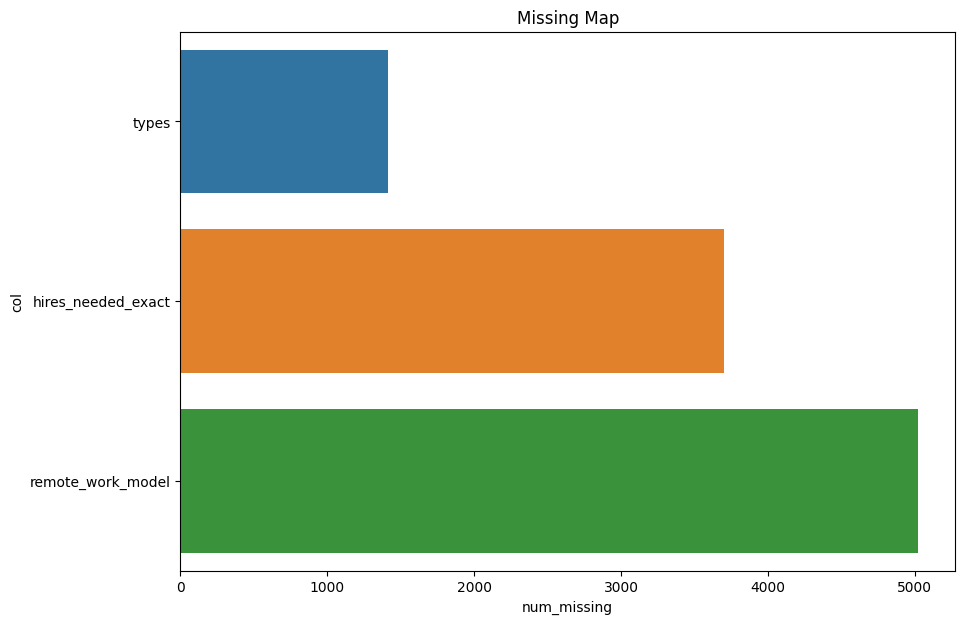

In [7]:
miss_cnt = df.isnull().sum()
print("missing value count:")
print(miss_cnt)
missing = miss_cnt[miss_cnt > 0]
if missing.empty:
    print("There are no missing values")
else:
    # print missing map
    missing.sort_values(inplace=True)
    missing_df = pd.DataFrame({'col': missing.index, 'num_missing': missing.values})

    plt.figure(figsize=(10,7))
    plt.title('Missing Map')
    sns.barplot(y='col', x='num_missing', data=missing_df)
    plt.show()

### Classification

In [8]:
df.columns

Index(['company', 'salary', 'rating', 'review_count', 'types', 'location',
       'hires_needed_exact', 'urgently_hiring', 'remote_work_model',
       'dradis_job', 'new_job', 'sponsored', 'featured_employer',
       'indeed_applyable', 'remote_location', 'hiring_event_job', 'salary_min',
       'salary_max', 'average_salary', 'salary_ratio', 'salary_range'],
      dtype='object')

In [9]:
# Separate features and target variable
X = df.drop(['salary', 'salary_min', 'salary_max', 'average_salary', 'salary_ratio', 'salary_range'], axis=1)
y = df['salary_range']

# Identify categorical columns
boolean_features = ['urgently_hiring', 'dradis_job', 'new_job', 'sponsored', 'featured_employer',
                    'indeed_applyable', 'remote_location', 'hiring_event_job']

categorical_features = ['types', 'remote_work_model', 'hires_needed_exact', 'company']

numerical_features = ['rating', 'review_count']

# Define preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define preprocessing for boolean and categorical data
boolean_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bool_cat', boolean_categorical_transformer, boolean_features + categorical_features)
    ])

# # Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the dataset into test (10%) and train (90%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Further split the training set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the target variable to binary format
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])


LogisticRegression

Logistic Regression Cross-Validation Scores: [0.86259542 0.87140341 0.85722679 0.85487662 0.86486486]
Logistic Regression Cross-Validated Accuracy: 0.86 +/- 0.01
Logistic Regression Validation Accuracy: 0.85
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       627
           1       0.80      0.86      0.83       542
           2       0.86      0.90      0.88       960

    accuracy                           0.85      2129
   macro avg       0.85      0.84      0.85      2129
weighted avg       0.86      0.85      0.85      2129

Validation Confusion Matrix:
[[485  43  99]
 [ 29 467  46]
 [ 26  71 863]]
Logistic Regression Val Micro Average AUC = 0.97
Logistic Regression Val Macro Average AUC = 0.97
Logistic Regression Val Class 0 AUC = 0.97
Logistic Regression Val Class 1 AUC = 0.97
Logistic Regression Val Class 2 AUC = 0.97


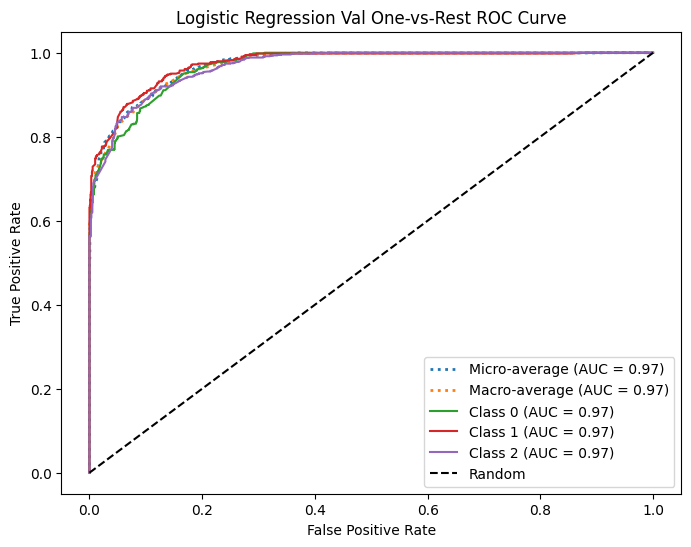

Logistic Regression Test Accuracy: 0.87
Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       348
           1       0.82      0.90      0.86       302
           2       0.87      0.91      0.89       533

    accuracy                           0.87      1183
   macro avg       0.88      0.87      0.87      1183
weighted avg       0.88      0.87      0.87      1183

Test Confusion Matrix:
[[275  19  54]
 [ 12 273  17]
 [  8  39 486]]
Logistic Regression Test Micro Average AUC = 0.98
Logistic Regression Test Macro Average AUC = 0.98
Logistic Regression Test Class 0 AUC = 0.98
Logistic Regression Test Class 1 AUC = 0.98
Logistic Regression Test Class 2 AUC = 0.97


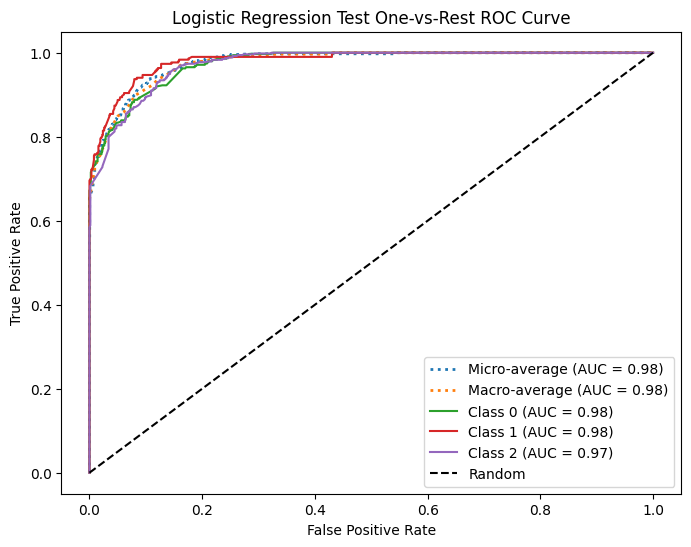

In [10]:
# Define the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("Logistic Regression Cross-Validation Scores:", cv_scores)
print(f"Logistic Regression Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Logistic Regression Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Val Micro Average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Val Macro Average AUC = {roc_auc_macro:.2f}")
# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Logistic Regression Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Logistic Regression Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Test Micro Average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Logistic Regression Test Macro Average AUC = {roc_auc_micro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Logistic Regression Test Class {i} AUC = {roc_auc[i]:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


SVM

SVM Cross-Validation Scores: [0.87081621 0.86788021 0.87485311 0.85252644 0.87250294]
SVM Cross-Validated Accuracy: 0.87 +/- 0.01
SVM Validation Accuracy: 0.86
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       627
           1       0.79      0.88      0.83       542
           2       0.88      0.89      0.88       960

    accuracy                           0.86      2129
   macro avg       0.86      0.85      0.85      2129
weighted avg       0.86      0.86      0.86      2129

Validation Confusion Matrix:
[[498  47  82]
 [ 28 476  38]
 [ 29  76 855]]
SVM Val Micro-average AUC = 0.96
SVM Val Macro-average AUC = 0.95
SVM Val Class 0 AUC = 0.96
SVM Val Class 1 AUC = 0.95
SVM Val Class 2 AUC = 0.95


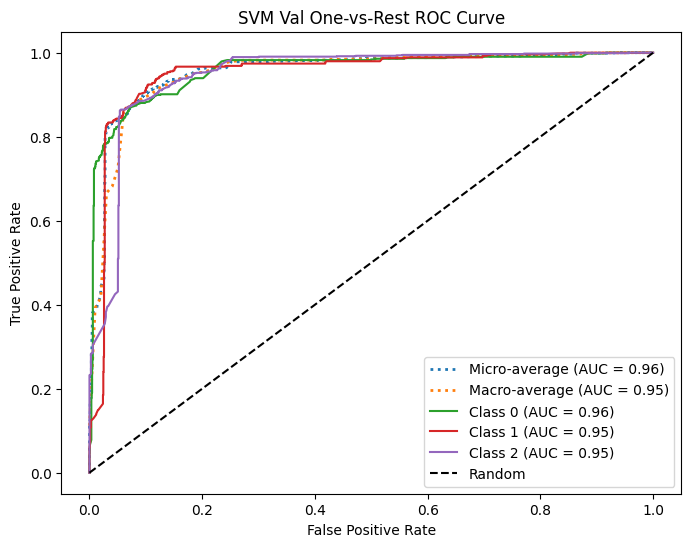

SVM Test Accuracy: 0.88
Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.86       348
           1       0.83      0.89      0.86       302
           2       0.88      0.91      0.90       533

    accuracy                           0.88      1183
   macro avg       0.88      0.87      0.87      1183
weighted avg       0.88      0.88      0.88      1183

Test Confusion Matrix:
[[285  16  47]
 [ 16 268  18]
 [ 10  38 485]]
SVM Test Micro-average AUC = 0.96
SVM Test Macro-average AUC = 0.95
SVM Test Class 0 AUC = 0.96
SVM Test Class 1 AUC = 0.95
SVM Test Class 2 AUC = 0.95


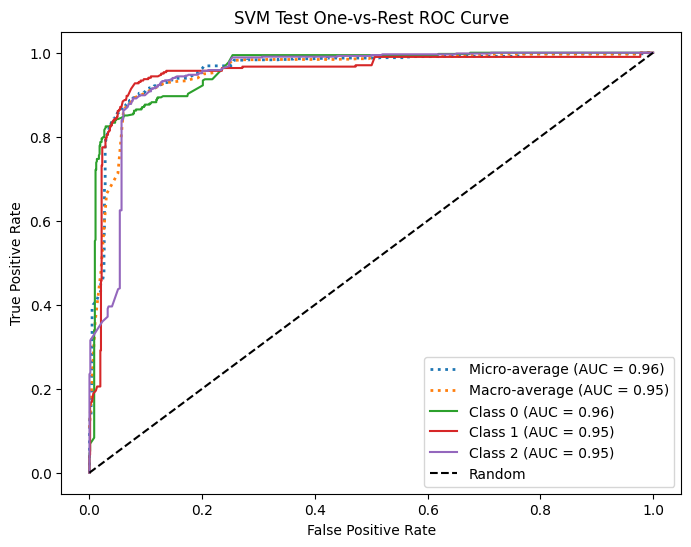

In [11]:
# Define the model
# model = SVC(C=10, probability=True, random_state=42, decision_function_shape='ovr', kernel='rbf')
model = SVC(C=10, probability=True, random_state=42, decision_function_shape='ovr', kernel='poly', gamma='scale',
            class_weight={0: class_weights[0], 1: class_weights[1], 2: class_weights[2]})

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("SVM Cross-Validation Scores:", cv_scores)
print(f"SVM Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"SVM Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Val Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Val Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"SVM Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"SVM Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Test Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"SVM Test Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"SVM Test Class {i} AUC = {roc_auc[i]:.2f}")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid to search
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Fit the model with the best hyperparameters on the entire training set
clf = grid_search.best_estimator_




DecisionTreeClassifier

Decision Tree Cross-Validation Scores: [0.873165   0.86494422 0.86075206 0.86251469 0.86016451]
Decision Tree Cross-Validated Accuracy: 0.86 +/- 0.00
Decision Tree Validation Accuracy: 0.86
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       627
           1       0.82      0.86      0.84       542
           2       0.87      0.91      0.89       960

    accuracy                           0.86      2129
   macro avg       0.86      0.85      0.85      2129
weighted avg       0.86      0.86      0.86      2129

Validation Confusion Matrix:
[[490  47  90]
 [ 32 464  46]
 [ 31  54 875]]
Decision Tree Val Micro-average AUC = 0.92
Decision Tree Val Macro-average AUC = 0.92
Decision Tree Val Class 0 AUC = 0.90
Decision Tree Val Class 1 AUC = 0.92
Decision Tree Val Class 2 AUC = 0.93


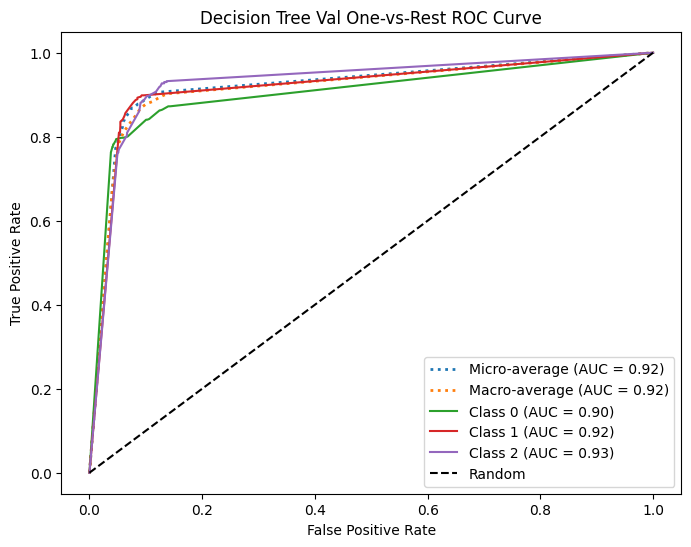

Decision Tree Test Accuracy: 0.86
Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       348
           1       0.84      0.85      0.84       302
           2       0.87      0.91      0.89       533

    accuracy                           0.86      1183
   macro avg       0.86      0.85      0.85      1183
weighted avg       0.86      0.86      0.86      1183

Test Confusion Matrix:
[[279  18  51]
 [ 27 256  19]
 [ 18  31 484]]
Decision Tree Test Micro-average AUC = 0.92
Decision Tree Test Macro-average AUC = 0.92
Decision Tree Test Class 0 AUC = 0.92
Decision Tree Test Class 1 AUC = 0.92
Decision Tree Test Class 2 AUC = 0.93


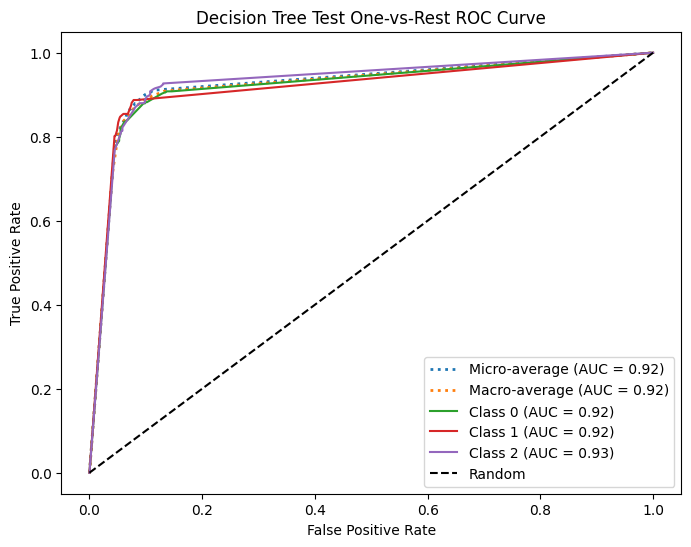

In [ ]:
# Define the model
model = DecisionTreeClassifier(random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("Decision Tree Cross-Validation Scores:", cv_scores)
print(f"Decision Tree Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Decision Tree Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Val Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Val Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Decision Tree Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Decision Tree Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Test Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Test Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Decision Tree Test Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


RandomForestClassifier

Random Forest Cross-Validation Scores: [0.87081621 0.86670581 0.86956522 0.86016451 0.86075206]
Random Forest Cross-Validated Accuracy: 0.87 +/- 0.00
Random Forest Validation Accuracy: 0.86
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       627
           1       0.82      0.85      0.83       542
           2       0.87      0.91      0.89       960

    accuracy                           0.86      2129
   macro avg       0.85      0.85      0.85      2129
weighted avg       0.86      0.86      0.86      2129

Validation Confusion Matrix:
[[489  51  87]
 [ 35 458  49]
 [ 30  52 878]]
Decision Tree Val Micro-average AUC = 0.98
Decision Tree Val Macro-average AUC = 0.97
Random Forest Val Class 0 AUC = 0.97
Random Forest Val Class 1 AUC = 0.98
Random Forest Val Class 2 AUC = 0.98


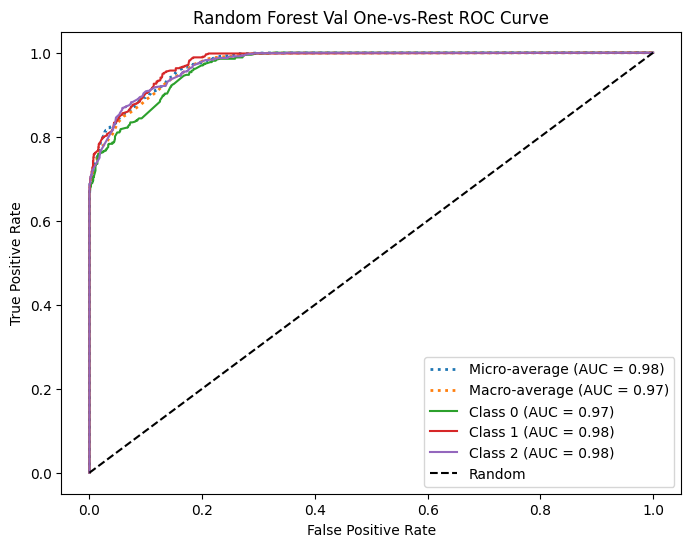

Random Forest Test Accuracy: 0.87
Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       348
           1       0.85      0.86      0.85       302
           2       0.87      0.92      0.90       533

    accuracy                           0.87      1183
   macro avg       0.87      0.86      0.86      1183
weighted avg       0.87      0.87      0.87      1183

Test Confusion Matrix:
[[281  17  50]
 [ 22 259  21]
 [ 13  30 490]]
Decision Tree Test Micro-average AUC = 0.98
Decision Tree Test Macro-average AUC = 0.98
Random Forest Test Class 0 AUC = 0.98
Random Forest Test Class 1 AUC = 0.98
Random Forest Test Class 2 AUC = 0.98


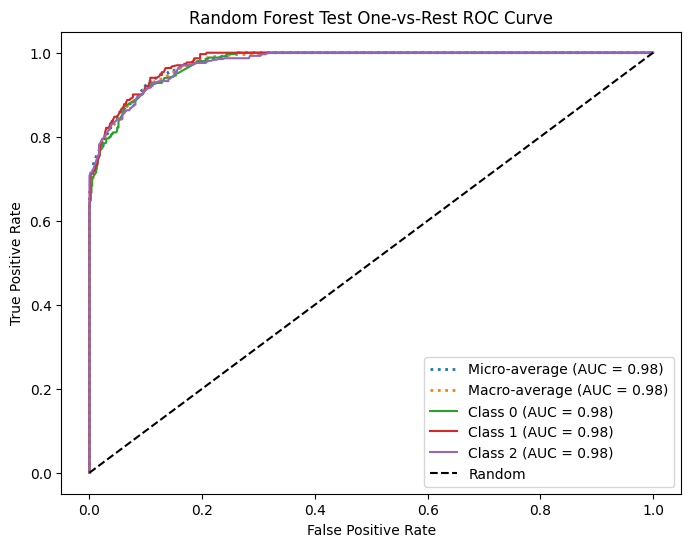

In [ ]:
# Define the model
model = RandomForestClassifier(n_estimators=200, random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Use cross-validation for better accuracy estimation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model using cross-validation on the training set
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validated accuracy
print("Random Forest Cross-Validation Scores:", cv_scores)
print(f"Random Forest Cross-Validated Accuracy: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")

# Fit the model on the entire training set
clf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = clf.predict(X_val)
y_val_pred_prob = clf.predict_proba(X_val)

# Evaluate the model on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Random Forest Validation Accuracy: {accuracy_val:.2f}")

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for the validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_val_bin.ravel(), y_val_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Val Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Val Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Random Forest Val Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Val One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Make predictions on the test set
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Random Forest Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for the test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Assuming you have 3 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(3):  # Assuming you have 3 classes
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= 3
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Test Micro-average AUC = {roc_auc_micro:.2f}")

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle=':', linewidth=2)
print(f"Decision Tree Test Macro-average AUC = {roc_auc_macro:.2f}")

# Plot individual class ROC curves
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    print(f"Random Forest Test Class {i} AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Test One-vs-Rest ROC Curve')
plt.legend(loc='lower right')
plt.show()


GridSearchCV

In [ ]:
feature_importances = clf.named_steps['classifier'].feature_importances_
feature_importances

array([2.30226451e-01, 2.91004379e-01, 2.82704064e-02, 2.98322566e-02,
       2.62929013e-02, 2.06258850e-02, 2.21279519e-02, 2.29288740e-02,
       1.99140558e-02, 2.10759449e-02, 1.47345300e-02, 1.31346741e-02,
       1.99473348e-02, 2.00338454e-02, 0.00000000e+00, 0.00000000e+00,
       2.27705608e-03, 1.64976352e-02, 1.52180179e-02, 1.72694712e-04,
       4.94417343e-04, 5.29553341e-03, 2.21749966e-03, 2.00895643e-04,
       2.10766365e-04, 3.83153450e-04, 5.03052892e-04, 1.07119516e-04,
       5.60250872e-04, 1.69429324e-03, 1.84856289e-04, 2.40980948e-02,
       2.52379310e-02, 3.09667937e-02, 1.66681936e-03, 2.16662346e-02,
       1.65861831e-02, 6.11849225e-03, 1.33980903e-02, 4.32224252e-03,
       2.61335062e-04, 1.33415575e-03, 4.62192622e-05, 1.57485817e-02,
       1.23820938e-02])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 50, 80, 100],
    'classifier__max_features': [2, 3, 5, 8, 10, 12],
    'classifier__min_samples_split': [2, 5, 10, 12, 15],
    'classifier__min_samples_leaf': [1, 2, 4, 5, 8]
    
}

grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the model
model = RandomForestClassifier(random_state=42)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Define hyperparameters to search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 50, 80, 100],
    'classifier__max_features': [2, 3, 5, 8, 10, 12],
    'classifier__min_samples_split': [2, 5, 10, 12, 15],
    'classifier__min_samples_leaf': [1, 2, 4, 5, 8]
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the validation set
y_val_pred = best_model.predict(X_val)

# Display classification report for the validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# Display confusion matrix for validation set
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Make predictions on the test set using the best model
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy_test:.2f}")

# Display classification report for the test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Display confusion matrix for test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


KeyboardInterrupt: 